# Simulating Argon Gas

This program simulates an Argon Gas.

## Importing packages

Importing the needed packages:

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

## Initialization

Initializes the needed variables. These are: <br>
N, the number of particles <br>
T, the temperature. <br>
m, the mass of a Argon particle <br>
rho, the density of the gas <br>
sigma, the interaction radius <br>
epsilon, the interaction strength <br>
h, timestep of the simulation <br>
<br>
The needed variables for each of N particles: position r, momentum p, and force f. These all have 3 components, in the x-, y-, and z-direction.

In [2]:
N = 4
T = 1
m = 1
rho = 1
sigma = 0.1
epsilon = 1
h = 0.1

p = np.zeros((N,3))
r = np.zeros((N,3))
f = np.zeros((N,3))
potential = np.zeros(N)

Now we define a function to set the positions according to a braivais-fcc lattice.

In [3]:
@jit
def initPositions(r,N,rho):
    
    #Compute lenght of sides of cube with volume V=N/rho
    L = (N/rho) ** (1/3)
    
    #Compute laticce constant a that fits all N atoms into V
    K = 1                                                             #Number of unit cell in one direction
    while (4 * (K ** 3)) < N:
        K = K + 1
    a = L/K
    
    #Set position particles in unit cell
    unit_cell = np.array([[0.0, 0.0, 0.0],[0.5*a, 0.5*a, 0.0],[0.5*a, 0.0, 0.5*a],[0.0, 0.5*a, 0.5*a]])
    
    #Place particles on the lattice until N = 4K^3
    n=0                                                               #Number of particles placed in lattice
    for i in range(K):
        for j in range(K):
            for k in range(K):
                for l in range(4):
                    if n<N:
                        r[n,0] = unit_cell[l,0]+i*a
                        r[n,1] = unit_cell[l,1]+j*a
                        r[n,2] = unit_cell[l,2]+k*a
                        n = n + 1
    return r

The momenta according to a Maxwell-Boltzmann distribution, keeping in mind that the particles can have negative velocities along the x-, y-, and z-direction. Subsequently the drift of the center of mass of the particles is shifted to zero and v is scaled to  force the desired temperature upon the gas. We define a function to do so.

In [4]:
@jit
def initMomentum(p,N,T):
    
    #Set the variance of the Gaussian distribution to k*T/m
    k = 1
    sigma = np.sqrt(k*T*m)
    mu = 0
    
    #Assign momentum components to all particles
    for n in range(N):
        p[n,0] = np.random.normal(mu,sigma,1)
        p[n,1] = np.random.normal(mu,sigma,1)
        p[n,2] = np.random.normal(mu,sigma,1)
            
    #Correct for drift of center of mass
    vCM = sum(p)/(N*m)                                         #Velocity of center of mass
    p[:,:] = p[:,:]-vCM*m
    
    return p

## Functions for Simulation

We start by defining a function to compute the forces on all particles. To do this we use Lennard-Jones potential for interaction and periodic boundary conditions. The boundary conditions require us to use the minimum image convention.

In [5]:
@jit
def computeForces(r,N,sigma,epsilon):
    L = (N/rho) ** (1/3)
    f = np.zeros((N,3))
    
    #Compute the distance between all particles
    for i in range(N-1):
        for j in range((i+1),N):
            rij = np.zeros(3)
            rij[0] = r[i,0]-r[j,0]
            rij[1] = r[i,1]-r[j,1]
            rij[2] = r[i,2]-r[j,2]
            
            #Apply minimum image convention
            if rij[0] > 0.5*L:
                if rij[0] > 0:
                    rij[0] = rij[0] - L
                else:
                    rij[0] = rij[0] + L
                    
            if rij[1] > 0.5*L:
                if rij[1] > 0:
                    rij[1] = rij[1] - L
                else:
                    rij[1] = rij[1] + L
                    
            if rij[2] > 0.5*L:
                if rij[2] > 0:
                    rij[2] = rij[2] - L
                else:
                    rij[2] = rij[2] + L
              
            #Calculating the force of pair ij
            rabs = (rij[0] ** 2 + rij[1] ** 2 + rij[2] ** 2)          #Absolute distance between pairs
            famp = 24*(epsilon/sigma)*(2*(sigma/rabs)**7 -(sigma/rabs)**4)
            
            f[i,0] = f[i,0]+rij[0]*famp
            f[j,0] = f[j,0]-rij[0]*famp
            
            f[i,1] = f[i,1]+rij[1]*famp
            f[j,1] = f[j,1]-rij[1]*famp
            
            f[i,2] = f[i,2]+rij[2]*famp
            f[j,2] = f[j,2]-rij[2]*famp
                
    return f   

In [6]:
@jit
def computePotential(r,N,sigma,epsilon):
    L = (N/rho) ** (1/3)
    potential = np.zeros(N)
    
    #Compute the distance between all particles
    for i in range(N-1):
        for j in range((i+1),N):
            rij = np.zeros(3)
            
            rij[0] = r[i,0]-r[j,0]
            rij[1] = r[i,1]-r[j,1]
            rij[2] = r[i,2]-r[j,2]
            
            #Apply minimum image convention
            if rij[0] > 0.5*L:
                if rij[0] > 0:
                    rij[0] = rij[0] - L
                else:
                    rij[0] = rij[0] + L
                    
            if rij[1] > 0.5*L:
                if rij[1] > 0:
                    rij[1] = rij[1] - L
                else:
                    rij[1] = rij[1] + L
                    
            if rij[2] > 0.5*L:
                if rij[2] > 0:
                    rij[2] = rij[2] - L
                else:
                    rij[2] = rij[2] + L
                        
            #Calculating the potential energy of each particle
            rabs = (rij[0] ** 2 + rij[1] ** 2 + rij[2] ** 2) ** (1/2)           #Absolute distance between pairs
            potential[i] = potential[i]+epsilon*((sigma/rabs)**12 -2*(sigma/rabs)**6)
            potential[j] = potential[j]+epsilon*((sigma/rabs)**12 -2*(sigma/rabs)**6)
                
    return potential  

We define a function which executes the Verlet algorithm to find the new position r and momentum p of each particle at a later time t+h.

In [7]:
@jit
def computeTimeStep(r,p,rho,N):
    L = (N/rho) ** (1/3)
    
    f = computeForces(r,N,sigma,epsilon)
    
    #Now we use the first equation to find the new r
    for i in range(N):
        p[i,0] = p[i,0] + (1/2)*f[i,0]*h
        p[i,1] = p[i,1] + (1/2)*f[i,1]*h
        p[i,2] = p[i,2] + (1/2)*f[i,2]*h
        
        r[i,0] = r[i,0] + (p[i,0]/m)*h
        r[i,1] = r[i,1] + (p[i,1]/m)*h
        r[i,2] = r[i,2] + (p[i,2]/m)*h
            
        #Place particle back into volume
        if r[i,0] >= L:
            r[i,0] = r[i,0] - L
        elif r[i,0] < 0:
            r[i,0] = r[i,0] + L
            
        if r[i,1] >= L:
            r[i,0] = r[i,0] - L
        elif r[i,1] < 0:
            r[i,0] = r[i,0] + L
            
        if r[i,1] >= L:
            r[i,0] = r[i,0] - L
        elif r[i,1] < 0:
            r[i,0] = r[i,0] + L
                   
        #Compute first part of new momentum
            
    
    #Update the forces to the new positions
    f = computeForces(r,N,sigma,epsilon)
    
    #Compute the second part of the new momentum
    for i in range(N):
            p[i,0] = p[i,0] + (1/2)*f[i,0]*h
            p[i,1] = p[i,1] + (1/2)*f[i,1]*h
            p[i,2] = p[i,2] + (1/2)*f[i,2]*h
    
    return r,p

## Running and plotting Simulation

In this part we use the functions defined above to run the simulation for N particles for a certain number of timesteps. 

<h3>Initialization</h3>

In [19]:
N = 108               #Number of particles
T = 1                   #Temperature of gas
m = 1                   #Mass of particles
rho = 1             #Density of gas
sigma = 1               #Interaction radius LJ potential
epsilon = 1             #Interaction strength LJ potential
h = 4e-3               #Size of timestep
steps = 1000            #Number of timesteps

p = np.zeros((N,3))     #Momenta of particles
r = np.zeros((N,3))     #Positions of particles
f = np.zeros((N,3))     #Forces on particles
potential = np.zeros(N) #Potential energy of particles

r = initPositions(r,N,rho);
p = initMomentum(p,N,T);

<h3>Simulate</h3>

Simulate to find r and p after a time $t = h * \text(steps)$.

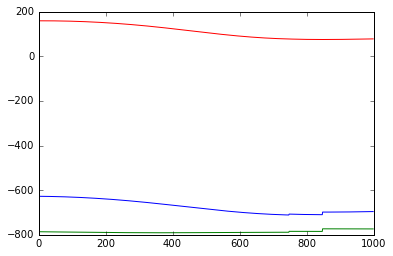

In [20]:
t = 0
E = np.zeros(steps)
Ep = np.zeros(steps)
Ek = np.zeros(steps)
while t<steps:
    output = computeTimeStep(r,p,rho,N)
    r = output[0]
    p = output[1]
    potential = computePotential(r,N,sigma,epsilon)

    for n in range(N):
        for i in range(3):
            Ek[t] = Ek[t] + (1/2)*(1/m)*(p[n,i] ** 2)
        Ep[t] = Ep[t] + potential[n]
    E[t] = Ep[t] + Ek[t]   
    t = t + 1
    
plt.figure()
plt.plot(range(steps),E)
plt.plot(range(steps),Ep)
plt.plot(range(steps),Ek)